# CNN with Modern Architecture
There are several techniques that can improve the performance of a CNN significantly by enhancing its ability to learn complex features, reducing its computational cost, and stabilizing its training process. The CNN proposed in this notebook implements some state-of-the-art techniques to get the best resutls possible. The CNN uses depthwise separable convolution, residual connections and batch normalization.

In [72]:

from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, TensorBoard
import os
from shutil import rmtree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

SOURCE = '/home/mniederer/workspace/data/cross_validation_normal/pass_6'
LOG_DIR = '/home/mniederer/workspace/Geo-KI/logs/CNN_material_new_data'
BATCH_SIZE = 25
EPOCHS = 45

# remove logs from previous executions
if os.path.isdir(os.path.join(LOG_DIR, 'train')):
    rmtree(os.path.join(LOG_DIR, 'train'))
if os.path.isdir(os.path.join(LOG_DIR, 'validation')):
    rmtree(os.path.join(LOG_DIR, 'validation'))


## Prepare Data for CNN
We employ the ImageDataGenerator class from the Keras library to prepare our data to be used in the CNN. The ImageDataGenerator resizes all images into shape [150,150,3] and prepares batches of size 32 to be processed by the CNN. Additionally we perform data augmentation on the training set. Our augmentation consists of randomly applying rotation, flipping, shifting, and brightness adjustment to each image.

In [73]:


# augmentation on training set
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.9,1.1],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )
train_generator = train_datagen.flow_from_directory(os.path.join(SOURCE,'train'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(os.path.join(SOURCE,'validation'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

# create test generator, important: shuffle=False so I can indentify the sources with test_generator.filenames
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(SOURCE,'test'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 4944 images belonging to 11 classes.
Found 1656 images belonging to 11 classes.


Found 1647 images belonging to 11 classes.


## Architecture of CNN Trained from Scratch
Our CNN architecture, trained from scratch, comprises an entry flow, a middle flow, and an exit flow. The entry flow gets a images of shape [150,150,3] and performs a first convolution with kernel size 5 on the input. The middle flow, the main part of the model, consists of five blocks. Each block applies depthwise separable convolutions, max pooling, and batch normalization. To prevent the vanishing gradient problem, each block has a residual connection around it. The exit flow implements the classifier of the CNN. It starts with a global average pooling layer to flatten the feature maps of the middle flow. Then, dropout is applied with a rate of 50\% to prevent overfitting. Finally three dense layers interpret the features from the middle flow and map them to the roof material classes.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv0 (Conv2D)                 (None, 150, 150, 32  2400        ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 Normalization1_1 (BatchNormali  (None, 150, 150, 32  128        ['Conv0[0][0]']                  
 zation)                        )                                                           

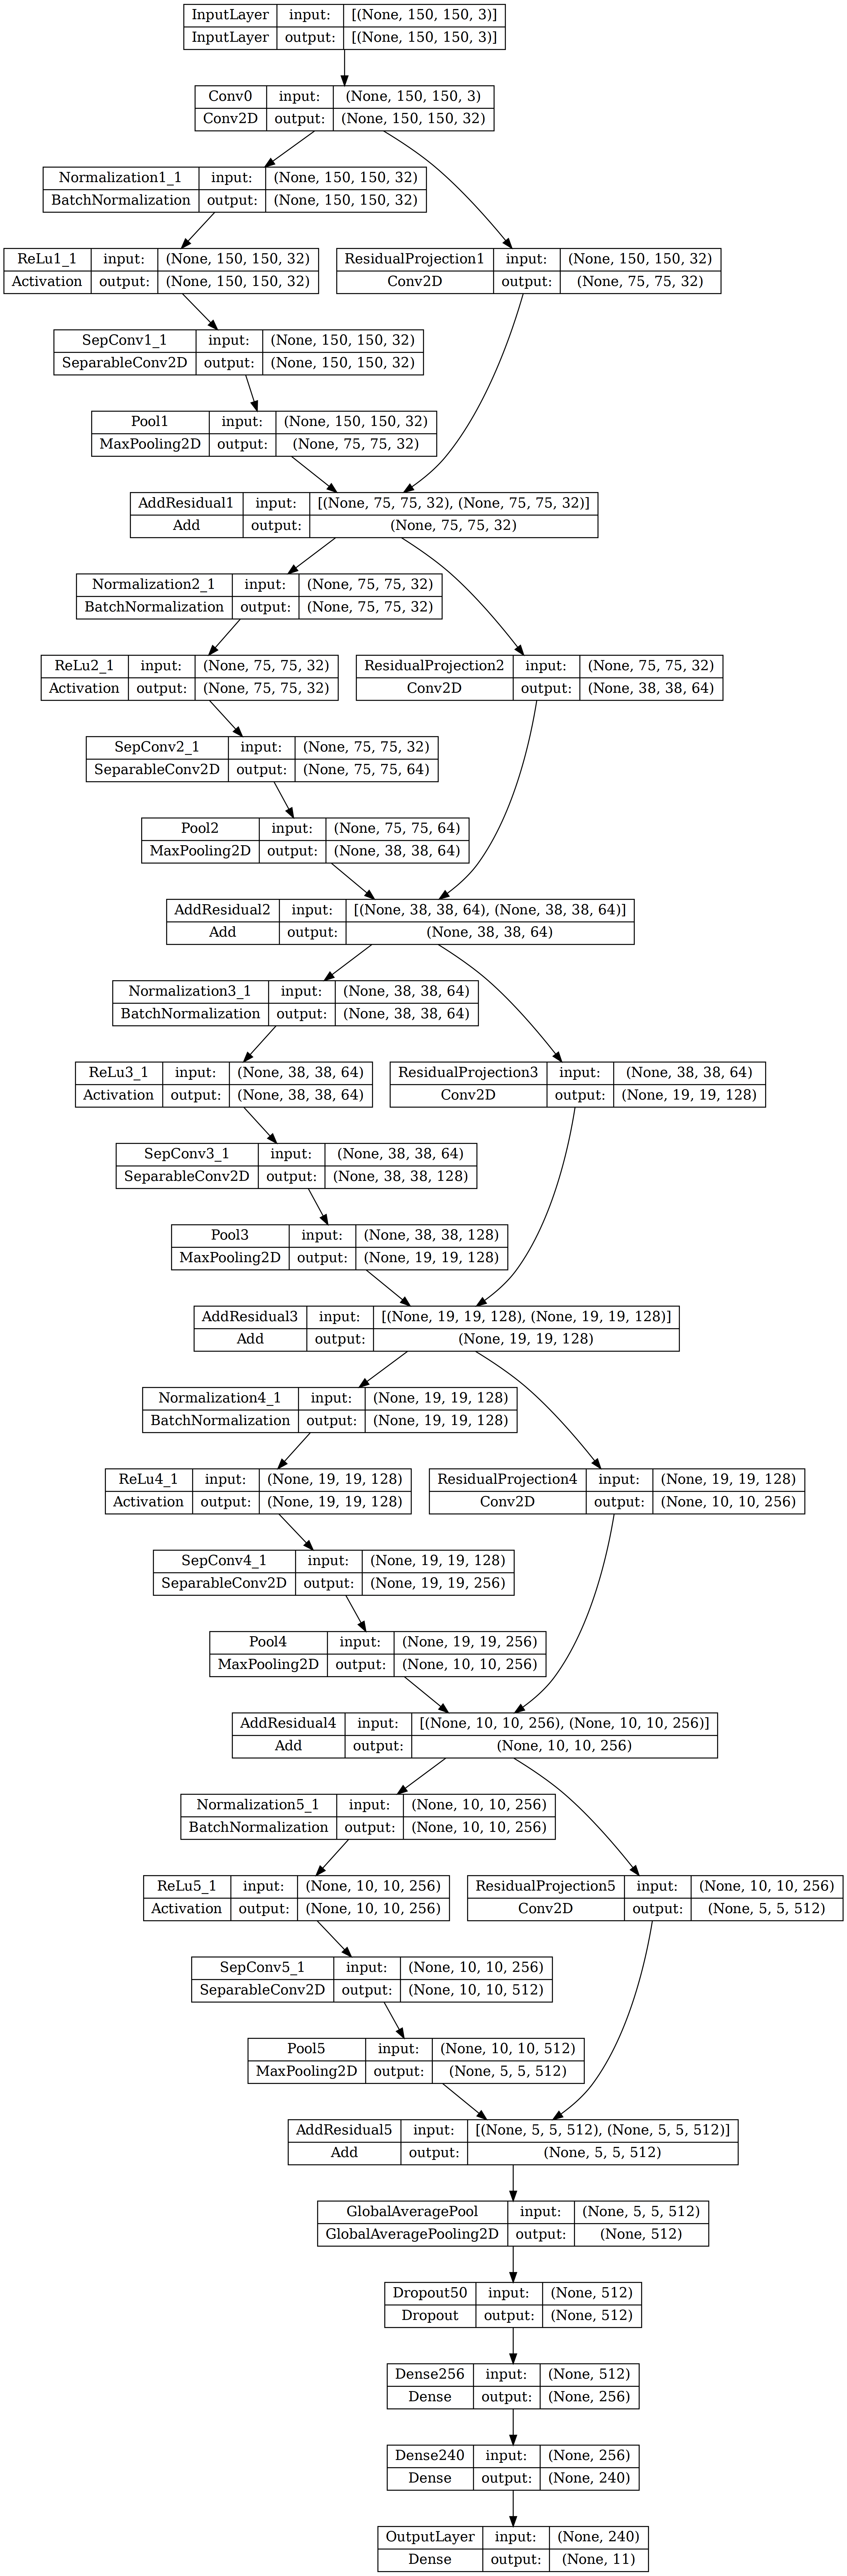

In [74]:
# entry flow
inputs = Input(shape=(150,150,3), name='InputLayer')
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False, name='Conv0', padding='same')(inputs)

# middle flow
for i in [1,2,3,4, 5]:
    size = pow(2,(i + 4))

    residual = x

    x = layers.BatchNormalization(name='Normalization'+str(i)+'_1')(x)
    x = layers.Activation("relu", name='ReLu'+str(i)+'_1')(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False, name= 'SepConv' + str(i) +'_1')(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same", name='Pool'+str(i))(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False, name='ResidualProjection'+str(i))(residual)
    x = layers.add([x, residual], name='AddResidual'+str(i))

# exit flow
x = layers.GlobalAveragePooling2D(name='GlobalAveragePool')(x) # flatten layer to connect to classifier
x = layers.Dropout(0.5, name='Dropout50')(x) # add Dropout to prevent overfitting

x = layers.Dense(256, activation='relu', name='Dense256')(x)
x = layers.Dense(240, activation='relu', name='Dense240')(x)
outputs = layers.Dense(11, activation='softmax', name='OutputLayer')(x)


# create model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

plot_model(model, to_file='Complex_CNN.png', show_shapes=True, expand_nested=True, dpi=250)

## Training model
To train our network, we use the Adam optimizer with a learning rate of 0.001 and the categorical crossentropy as the loss function. We set the batch size to 32 and run the training for 45 epochs. We also apply the EarlyStopping callback to terminate the training early if the network does not improve for 10 consecutive epochs. We use TensorBoard to monitor the training metrics and visualize the network performance.

In [75]:
early_stopping_callback = EarlyStopping('val_accuracy', patience=15, min_delta=0.001, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
          callbacks=[early_stopping_callback],
          validation_data=validation_generator)


Epoch 1/45
198/198 [==============================] - 166s 829ms/step - loss: 1.3576 - accuracy: 0.5514 - val_loss: 1.8331 - val_accuracy: 0.3967
Epoch 2/45
198/198 [==============================] - 162s 818ms/step - loss: 1.2510 - accuracy: 0.5864 - val_loss: 1.4978 - val_accuracy: 0.5024
Epoch 3/45
198/198 [==============================] - 156s 784ms/step - loss: 1.2251 - accuracy: 0.5880 - val_loss: 1.3947 - val_accuracy: 0.5773
Epoch 4/45
198/198 [==============================] - 154s 776ms/step - loss: 1.2060 - accuracy: 0.6009 - val_loss: 1.8698 - val_accuracy: 0.4940
Epoch 5/45
198/198 [==============================] - 153s 774ms/step - loss: 1.1606 - accuracy: 0.6082 - val_loss: 1.6287 - val_accuracy: 0.5719
Epoch 6/45
198/198 [==============================] - 153s 772ms/step - loss: 1.1547 - accuracy: 0.6163 - val_loss: 1.2191 - val_accuracy: 0.5791
Epoch 7/45
198/198 [==============================] - 153s 772ms/step - loss: 1.1366 - accuracy: 0.6155 - val_loss: 1.3534 -

### Plot Training Process
We plot the training process of the CNN to evaluate the training.

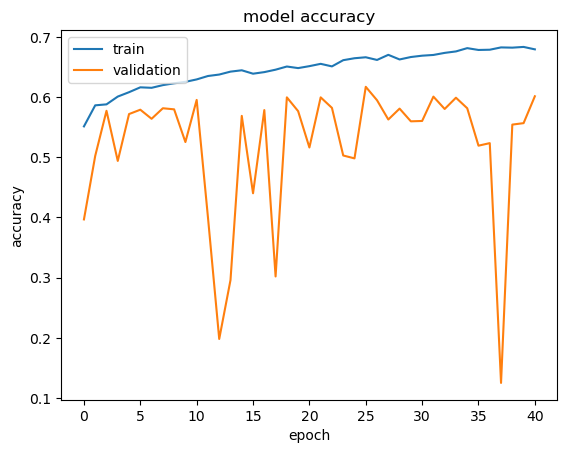

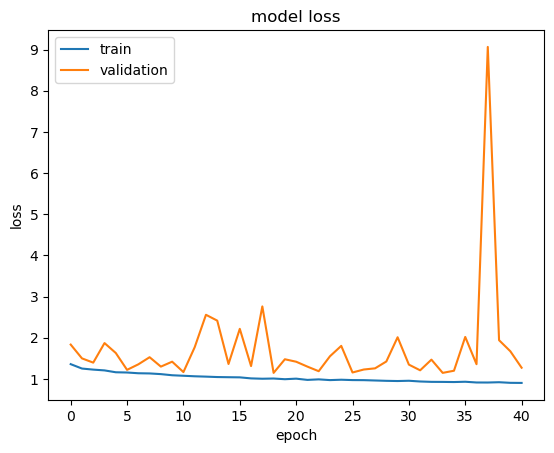

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation
We test our CNN model on the test set to evaluate the performance of our model.

In [77]:
score=model.evaluate(test_generator)

print("Test score:", score[0])
print("Test accuracy:", score[1])

y_test = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_test, y_pred))

57/66 [========================>.....] - ETA: 0s - loss: 1.1482 - accuracy: 0.5944

66/66 [==============================] - 4s 62ms/step - loss: 1.0490 - accuracy: 0.6351
Test score: 1.0490331649780273
Test accuracy: 0.6350941061973572
66/66 [==============================] - 4s 63ms/step
              precision    recall  f1-score   support

           0       0.65      0.35      0.45       179
           1       0.36      0.09      0.14       159
           2       0.60      0.18      0.27       148
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00         2
           7       0.36      0.81      0.50       259
           8       0.00      0.00      0.00        27
           9       0.88      0.25      0.39        28
          10       0.83      0.89      0.86       814

    accuracy                           0.64      1647
   macro avg       0.37      0.26      0.26      1647
weighted avg       0.64      0.64      0.60      1647



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### Save CNN

In [78]:
model.save('CNN_complex.h5')